<a href="https://colab.research.google.com/github/ArmPeerapat/BADS7105_CRM/blob/main/code/HW2_Inception_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Prepare the environment

In [ ]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-a2479eee-900b-423e-c512-92828bc1cbd1)


In [ ]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}" )

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.experimental.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
    print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0]

NumPy 1.21.5
TensorFlow 2.8.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [ ]:
# Set fixed seedding values for reporoducability during experiments
# Skip this if random initialization (with varied results) is needed
np.random.seed(1234)
tf.random.set_seed(5678)

# 2. Prepare our dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pathlib
import os

myFile = "raw_data_image.tar.gz"
fullPath = os.path.abspath("./drive/MyDrive/Colab Notebooks/BADS7604/Group_HW2/" + myFile)

data_dir = tf.keras.utils.get_file(myFile, 'file://'+fullPath, untar=True)
data_dir = pathlib.Path(data_dir)

616472576/616459212 [==============================] - 8s 0us/step


In [ ]:
# Check images accepted by TensorFlow
import imghdr

image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in pathlib.Path(data_dir).rglob("*"):
  if filepath.suffix.lower() in image_extensions:
    img_type = imghdr.what(filepath)
    if img_type is None:
      print(f"{filepath} is not an image")
    elif img_type not in img_type_accepted_by_tf:
      print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

569


In [ ]:
len_atmosphere = len(list(data_dir.glob('atmosphere/*.jpg')))
len_food = len(list(data_dir.glob('food/*.jpg')))
len_menu = len(list(data_dir.glob('menu/*.jpg')))

print(len_atmosphere, len_food, len_menu)

200 200 169


In [ ]:
img_size = (299, 299)
data = []
labels = []

for i in data_dir.glob('atmosphere/*.jpg'):   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size = img_size)
    image=np.array(image)
    data.append(image)
    labels.append(0)

for i in data_dir.glob('food/*.jpg'):   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size = img_size)
    image=np.array(image)
    data.append(image)
    labels.append(1)

for i in data_dir.glob('menu/*.jpg'):   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size = img_size)
    image=np.array(image)
    data.append(image)
    labels.append(2)

data = np.array(data)
labels = np.array(labels)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels, shuffle=True)

In [ ]:
print(f"x_train: type={type(x_train)}, dtype={x_train.dtype}, shape={x_train.shape}, min={x_train.min(axis=None)}, max={x_train.max(axis=None)}")
print(f"y_train: type={type(y_train)}, dtype={y_train.dtype}, shape={y_train.shape}, min={min(y_train)}, max={max(y_train)}")
print(f"x_test: type={type(x_test)}, dtype={x_test.dtype}, shape={x_test.shape}, min={x_test.min(axis=None)}, max={x_test.max(axis=None)}")
print(f"y_test: type={type(y_test)}, dtype={y_test.dtype}, shape={y_test.shape}, min={min(y_test)}, max={max(y_test)}")

x_train: type=<class 'numpy.ndarray'>, dtype=uint8, shape=(455, 299, 299, 3), min=0, max=255
y_train: type=<class 'numpy.ndarray'>, dtype=int64, shape=(455,), min=0, max=2
x_test: type=<class 'numpy.ndarray'>, dtype=uint8, shape=(114, 299, 299, 3), min=0, max=255
y_test: type=<class 'numpy.ndarray'>, dtype=int64, shape=(114,), min=0, max=2


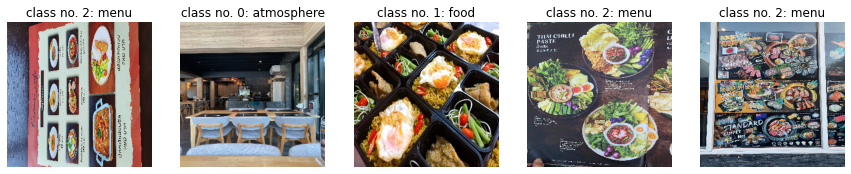

In [ ]:
class_names = ["atmosphere", "food", "menu"]

# Visualize the first five images in x_train
plt.figure(figsize=(15, 5))
for i in range(5):
  plt.subplot(150 + 1 + i).set_title(f"class no. {y_train[i]}: {class_names[int(y_train[i])]}")
  plt.imshow(x_train[i])
  plt.axis("off")
plt.show()

In [ ]:
# Build data augmentation layer
data_augmentation = tf.keras.Sequential([
                                         tf.keras.layers.RandomFlip('horizontal'),
                                         tf.keras.layers.RandomRotation(0.2),
                                         ])

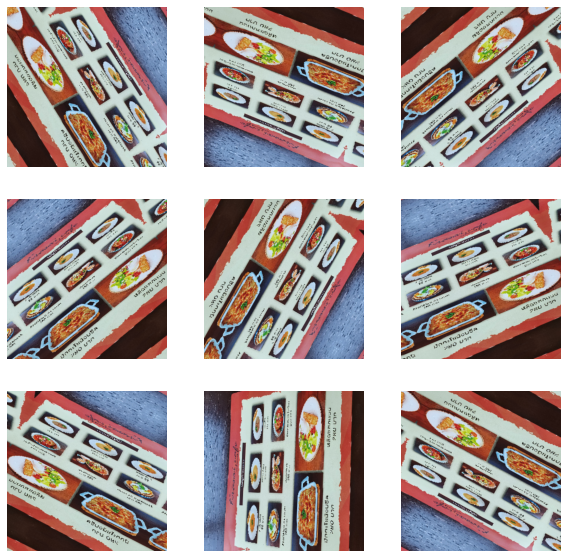

In [ ]:
# Visualize the first image of data augmentation
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  augmented_image = data_augmentation(x_train)
  plt.imshow(augmented_image[0] / 255)
  plt.axis('off')

In [ ]:
# Build preprocess layer to match Inception V3's requirements
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

# 3. Load the pretrained model (only the feature extractor)

In [ ]:
# Load the ImageNet Inception V3 model, ***excluding*** the latter part regarding the classifier
# Default of input shape is 299x299x3 for Inception V3
img_w, img_h = 299, 299
incep_extractor = tf.keras.applications.inception_v3.InceptionV3(weights= "imagenet", include_top=False, input_shape=(img_w, img_h, 3))

incep_extractor.summary()

87924736/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)           

# 4. Prepare for transfer learning and finetuning
- Add the new classification head
- Decide wheather to freeze or unfreeze any pretrained layers

## 4.1 Access and freeze layer(s) in Keras's model

In [ ]:
# Recursively freese all layers in the model
incep_extractor.trainable = False

for i, layer in enumerate(incep_extractor.layers):
  print(f"Layer {i}: name = {layer.name}, = trainable = {layer.trainable}")

Layer 0: name = input_1, = trainable = False
Layer 1: name = conv2d, = trainable = False
Layer 2: name = batch_normalization, = trainable = False
Layer 3: name = activation, = trainable = False
Layer 4: name = conv2d_1, = trainable = False
Layer 5: name = batch_normalization_1, = trainable = False
Layer 6: name = activation_1, = trainable = False
Layer 7: name = conv2d_2, = trainable = False
Layer 8: name = batch_normalization_2, = trainable = False
Layer 9: name = activation_2, = trainable = False
Layer 10: name = max_pooling2d, = trainable = False
Layer 11: name = conv2d_3, = trainable = False
Layer 12: name = batch_normalization_3, = trainable = False
Layer 13: name = activation_3, = trainable = False
Layer 14: name = conv2d_4, = trainable = False
Layer 15: name = batch_normalization_4, = trainable = False
Layer 16: name = activation_4, = trainable = False
Layer 17: name = max_pooling2d_1, = trainable = False
Layer 18: name = conv2d_8, = trainable = False
Layer 19: name = batch_norm

## 4.2 Add a new classification head

In [ ]:
inputs = tf.keras.Input(shape=(img_w, img_h, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = incep_extractor(x)

# Add our custom layer(s) to the end of the existing model
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(3, activation="softmax")(x)

# Construct the main model
model = tf.keras.models.Model(inputs=inputs, outputs=new_outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0     

# 5. Train the model with transfer learning
No finetuning is done in this example as all pretrained layers are freezed and only newly added layers are trained.

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])

In [ ]:
history = model.fit(x_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
3/3 [==============================] - 32s 6s/step - loss: 47.7441 - acc: 0.4066 - val_loss: 60.7604 - val_acc: 0.4725
Epoch 2/20
3/3 [==============================] - 2s 583ms/step - loss: 39.5931 - acc: 0.6181 - val_loss: 15.7754 - val_acc: 0.7253
Epoch 3/20
3/3 [==============================] - 2s 587ms/step - loss: 26.6513 - acc: 0.7060 - val_loss: 3.1367 - val_acc: 0.9231
Epoch 4/20
3/3 [==============================] - 2s 585ms/step - loss: 5.5635 - acc: 0.9176 - val_loss: 2.8803 - val_acc: 0.9560
Epoch 5/20
3/3 [==============================] - 2s 590ms/step - loss: 5.5357 - acc: 0.8791 - val_loss: 4.4550 - val_acc: 0.9451
Epoch 6/20
3/3 [==============================] - 2s 587ms/step - loss: 5.0083 - acc: 0.8956 - val_loss: 1.5873 - val_acc: 0.9670
Epoch 7/20
3/3 [==============================] - 2s 592ms/step - loss: 3.4482 - acc: 0.9533 - val_loss: 1.9118 - val_acc: 0.9451
Epoch 8/20
3/3 [==============================] - 2s 589ms/step - loss: 5.6448 - acc: 0

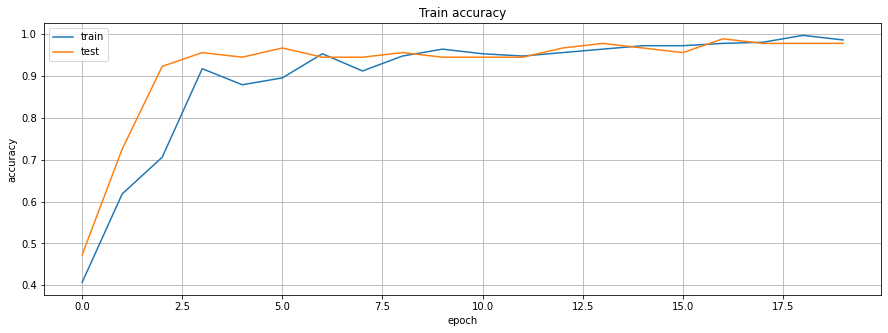

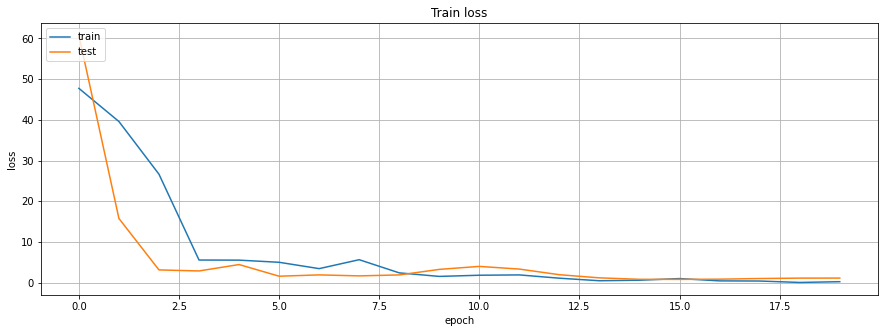

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("Train accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

# Summarize history for loss
plt.figure(figsize=(15, 5))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Train loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

# 6. Evaluate the model on test set

In [ ]:
# Evaluate the trained model on the test set
results = model.evaluate(x_test, y_test, batch_size=128)
print(f"{model.metrics_names}: {results}")

1/1 [==============================] - 6s 6s/step - loss: 0.7147 - acc: 0.9649
['loss', 'acc']: [0.7146731019020081, 0.9649122953414917]


In [ ]:
from sklearn.metrics import classification_report
predict = model.predict(x_test)
predict_ = np.argmax(predict, axis=-1)
print(f"Classification Report\n{classification_report(y_test, predict_)}")

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        40
           1       0.97      0.97      0.97        40
           2       1.00      0.94      0.97        34

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.97       114
weighted avg       0.97      0.96      0.97       114



Confusion Matrix
[[39  1  0]
 [ 1 39  0]
 [ 2  0 32]]


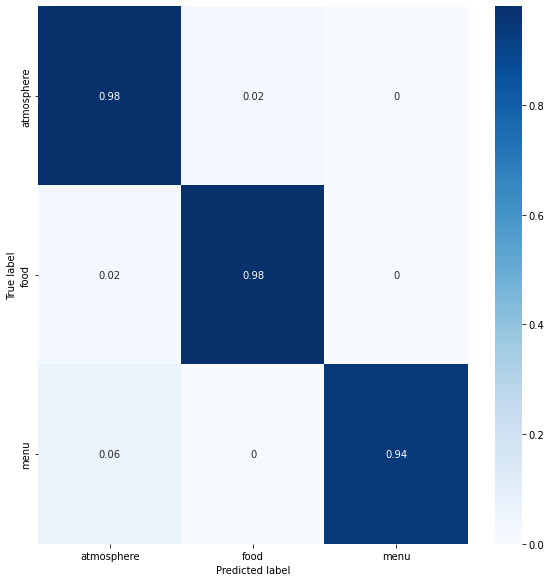

In [ ]:
import pandas as pd
import seaborn as sns

con_mat = tf.math.confusion_matrix(labels=y_test, predictions=predict_).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm, index=class_names, columns=class_names)
print(f'Confusion Matrix\n{con_mat}')
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

ROC AUC score: 0.9729


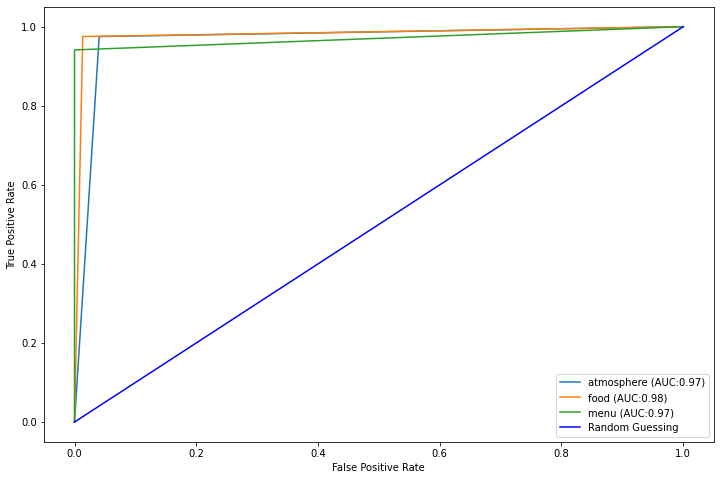

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  for (idx, c_label) in enumerate(class_names):
    fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
  c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
  return roc_auc_score(y_test, y_pred, average=average)


print(f'ROC AUC score: {multiclass_roc_auc_score(y_test, predict_):.4f}')

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

# 7. Inference

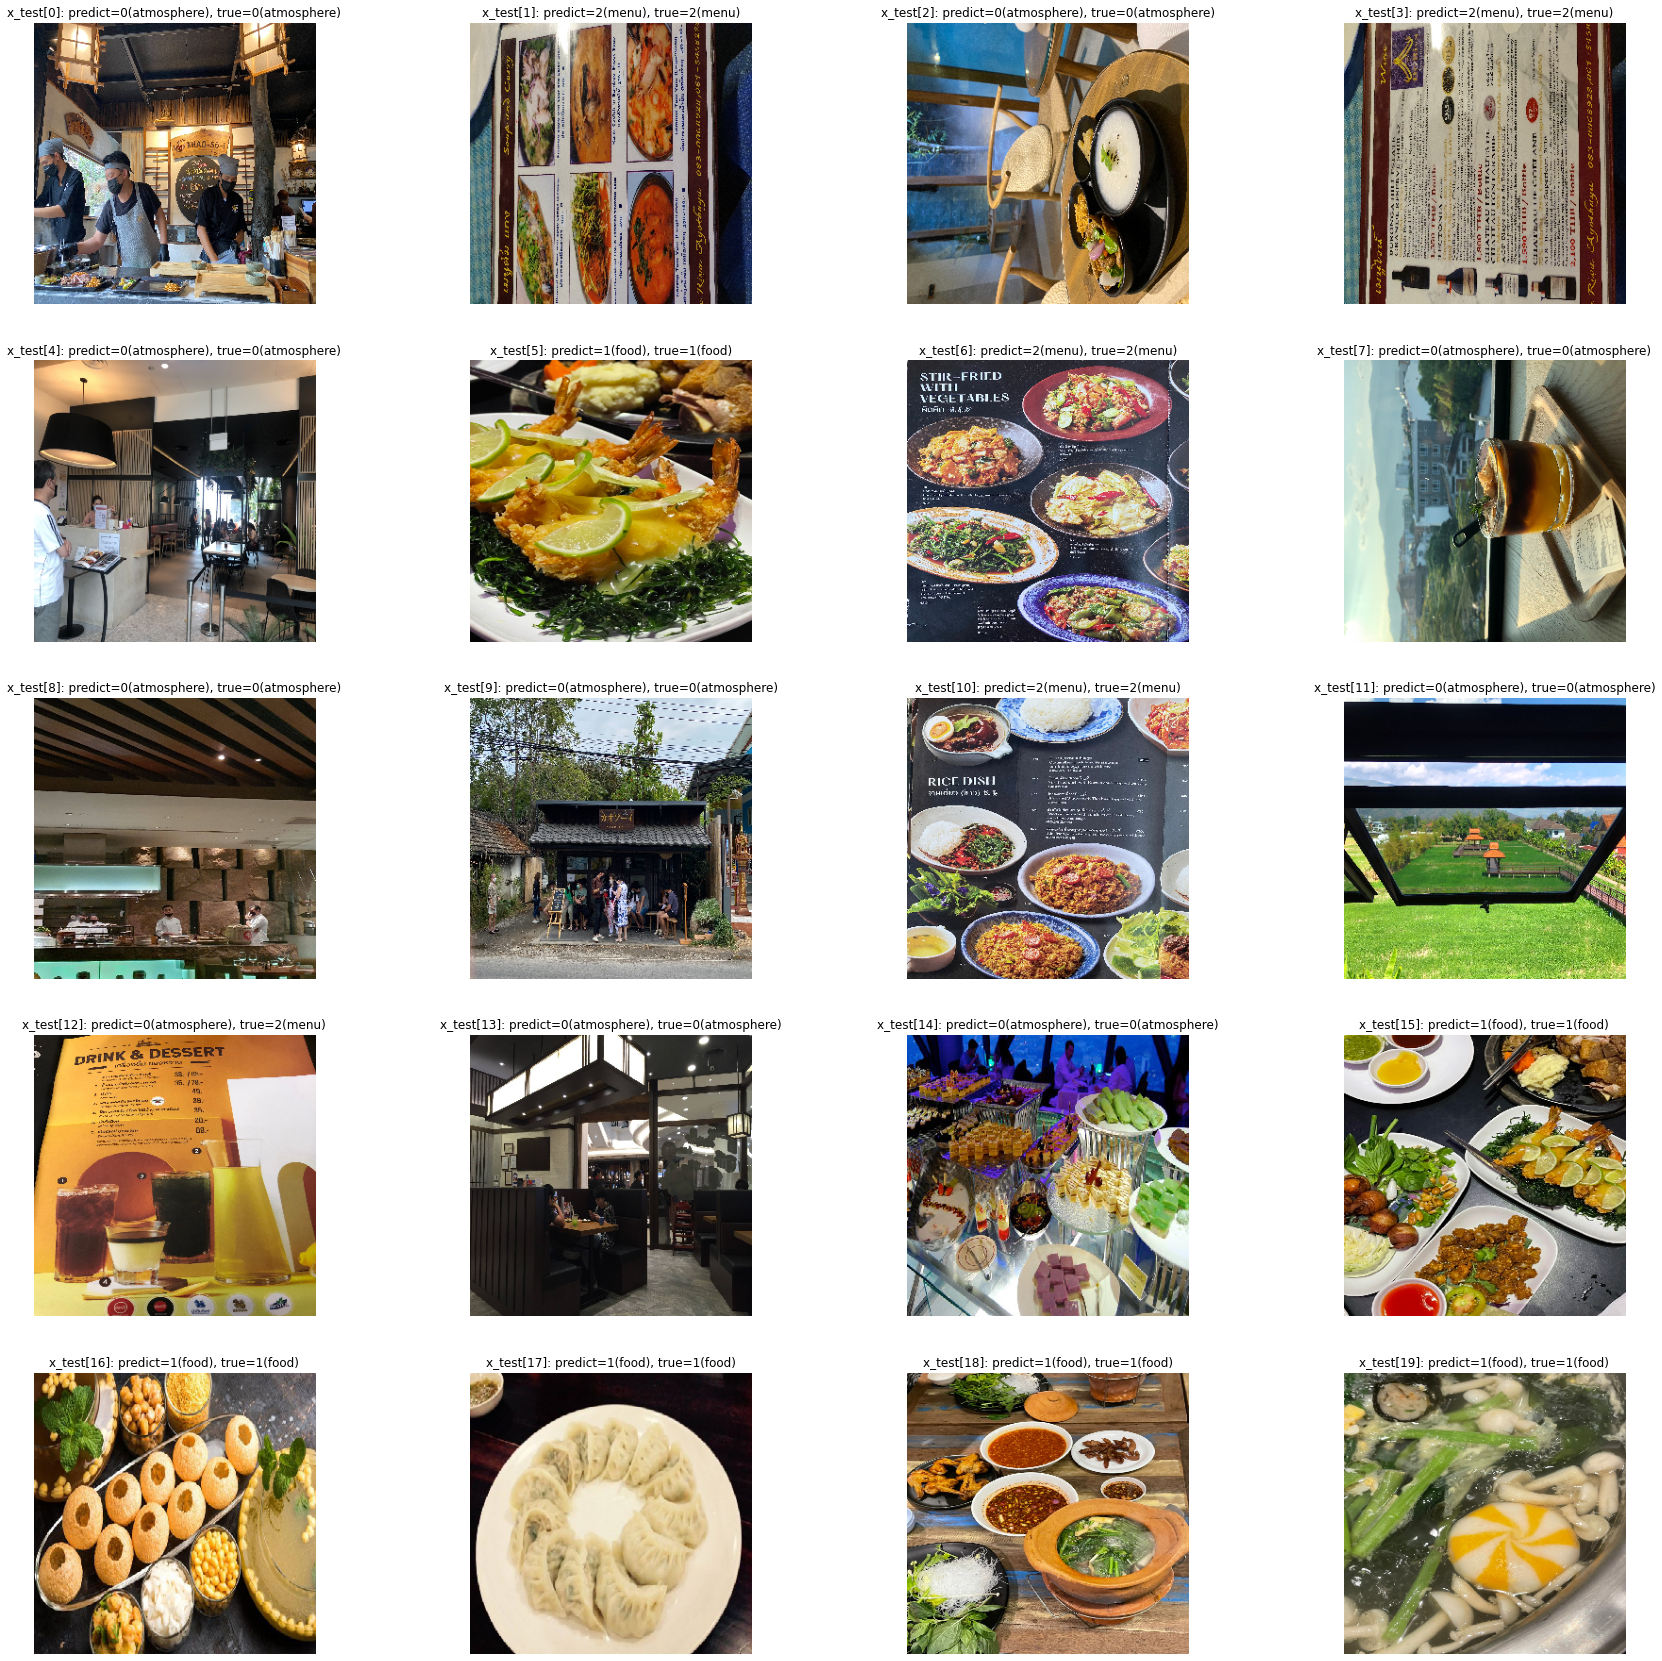

In [ ]:
# Test using the model on the first 20 images in x_test
plt.figure(figsize=(30, 30))
for i in range(20):
  y_pred = model.predict(x_test[i].reshape(1,img_w,img_h,3))
  
  ax = plt.subplot(5, 4, i + 1)
  plt.imshow(x_test[i])
  plt.title(f"x_test[{i}]: predict={np.argmax(y_pred)}({class_names[np.argmax(y_pred)]}), true={y_test[i]}({class_names[int(y_test[i])]})")
  plt.axis("off")